# Course4
## Time Series and Prediction
## Week4

This week, you'll go one step further, combining convolutions with LSTMs to get a very nicely fitting model.

In [10]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# LSTM

Here's the LSTM that you looked at last week, except that I've **added conv1D** where we'll try to **learn 32 filters.** It's a one dimensional convolution. So we'll **take a five number window and multiply output values in that window by the filter values, in much the same way as image convolutions are done.**

One important note is that while we **got rid of the Lambda layer** that reshaped the input for us to work with the LSTM's. So **we're actually specifying an input shape on the conv1D here**. This requires us to **update the windowed_datasetet helper function** that we've been working with all along.

We'll simply **use tf.expand_dims** in the helper function to expand the dimensions of the series before we process it.

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
train_set = train_set.padded_batch(batch_size, tf.compat.v1.data.get_output_shapes(train_set))   #

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32,
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


NotImplementedError: Cannot convert a symbolic Tensor (bidirectional/forward_lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

### Set the Learning Rate

Also similar to last week, the code will attempt lots of different learning rates changing them epoch by epoch and plotting the results. With this data and the convolutional and LASTM-based network, we'll get a plot like this.

**Bottoms** are around 10 to the -5 after which it looks a bit unstable, so we'll take that to be our **desired learning rates.**

Thus when we define the **optimizer will set the learning rate to be 1e-5** as shown here.

[1e-08, 0.0001, 0, 30]

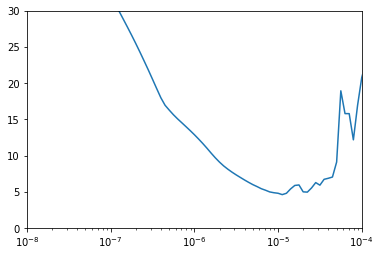

In [70]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

When we train for 500 epochs we'll get this curve. It's a huge improvement over earlier. The peak has lost its plateau but it's still not quite right, it's not getting high enough relative to the data.

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32,
                         kernel_size=3,
                         strides=1,
                         padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset,epochs=500)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [72]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Now of course **noise** is a factor and we can see crazy fluctuations in the peak caused by the noise, but I think our model could possibly do a bit better than this. Our MAE is below 5, but I would bet that outside of that first peak is probably a lot lower than that.

- One solution might be to **train a little bit longer.** Even though our MAE loss curves look flat at 500 epochs, we can see when we zoom in that they're slowly diminishing. The network is still learning albeit slowly.
- Now one method would be to **make your LASTMs bidirectional** like this. When training, this looks really good giving very low loss in MAE values sometimes even less than one. But unfortunately it's **overfitting** when we plot the predictions against the validation set, we don't see much improvement and in fact our MAE has gone down. So it's still a step in the right direction and consider an architecture like this one as you go forward, but perhaps **you might need to tweak some of the parameters to avoid overfitting.**

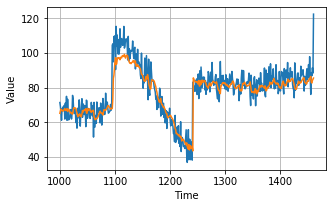

In [73]:
plt.figure(figsize=(5, 3))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [74]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0907764

Some of the problems are clearly visualize when we **plot the loss against the MAE,** there's a lot of noise and instability in there. **One common cause for small spikes** like that is a **small batch size** introducing further random noise.

I won't go into the details here, but if you check out Andrea's videos and his course on optimizing for gradient descent, there's some really great stuff in there. One hint was to explore the batch size and to make sure it's appropriate for my data. So in this case it's worth experimenting with different batch sizes.

More on batch sizing : https://www.youtube.com/watch?v=4qJaSmvhxi8

<Figure size 432x288 with 0 Axes>

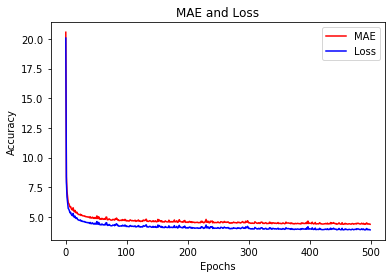

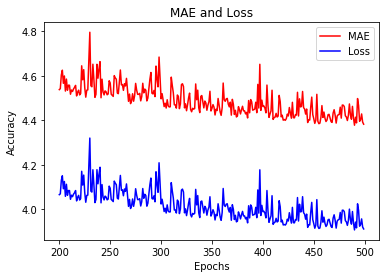

<Figure size 432x288 with 0 Axes>

In [75]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Sunspots data

It's an average monthly amount that should be at the end of that month. You can download it from Kaggle. It's a pretty simple dataset, but it does help us understand a little bit more about how to optimize our code to predict the dataset based on the nature of its underlying data. Of course, one size does not fit all particularly when it comes to data that has seasonality. So let's take a look at the code.

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

In [127]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [128]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

### Open CSV File

Here's the code to read the CSV file and get its data into a list of sunspots and timestamps.

- We'll start by importing the CSV library.
- Then we'll open the file.
- This line, **next(reader)**, simply reads **the first line** and we end up **throwing it away**. That's because **the column titles are in the first line of the file** as you can see here.
- Then, we will look through the reader reading the file line by line. Our sunspots are actually in column 2 and we want them to be **converted into a float.** As the file is read, **every item will be read as a string** so we may as well convert them now instead of iterating through the list later and then converting all the datatypes. Similarly, we'll read **the time steps as integers.**

In [1]:
import csv
time_step = []
sunspots = []

with open('source/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

### Convert a list to NumPy arrays

It's more efficient to do it this way,build-up your data in a throwaway list and then convert it to NumPy than I would have been to start with NumPy arrays, because every time you append an item to a NumPy, **there's a lot of memory management** going on to clone the list, maybe a lot of data that can get slow.

In [2]:
series = np.array(sunspots)
time = np.array(time_step)

NameError: name 'np' is not defined

### Plot the data

Note that we have **seasonality,** but it's not very regular with some peaks and much higher than others. We also have quite **a bit of noise,** but there's **no general trend.**

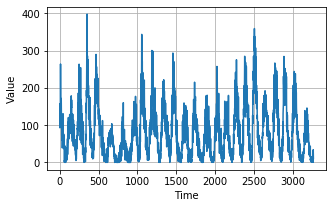

In [131]:
plt.figure(figsize=(5, 3))
plot_series(time, series)

### Split our Series into a Training and Validation datasets

We'll split at time 1,000. We'll have a window size of 20, batch size of 32, and a shuffled buffer of 1,000. We'll use the same window dataset code that we've been using all week to turn a series into a dataset which we can train on.

In [132]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [133]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

We'll go back to the simple DNN that we saw way back in week two for training on and we'll see what happens.

In [134]:
ds = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(ds, epochs=100, verbose=0)

In [135]:
forecast=[]
for time in range(len(series) - window_size):
    # np.newaxis : expand the dimmension
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

We get a chart like this, which at least to the eyeball looks really good, but it has a very large MAE so something must be wrong. Indeed, if we zoom into the results we can see in a little bit more detail about how the forecast behaves in the original data.

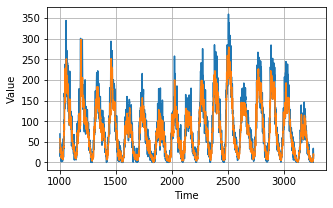

In [136]:
plt.figure(figsize=(5, 3))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [137]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

19.089603

### Increase the Window Size to 132

Our clue to the problem could be our **window size.**

Remember earlier we said it's a 20 so our training window sizes are 20 time slices worth of data. And given that each time slice is a month in real time our window is a little under two years.

But if you remember this chart, we can see that the **seasonality of sunspots is far greater than two years.** It's closer to 11 years. And actually some science tells us that it might even be 22 years with different cycles interleaguing with each other. So what would happen if we **retrain with a window size of 132,** which is 11 years worth of data as our window size.

In [141]:
window_size = 132
batch_size = 32
shuffle_buffer_size = 1000

In [142]:
ds = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(ds, epochs=100, verbose=0)

In [143]:
forecast=[]
for time in range(len(series) - window_size):
    # np.newaxis : expand the dimmension
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

We can see from the **MAE that it actually got worse** so increasing the window size didn't work. Why do you think that would be? Well, by looking back to the data, we can realize that it is seasonal to about 11 years, but we don't need a full season in our window. Zooming in on the data again, we'll see something like this, where it's just the typical time series. Values later on are somewhat related to earlier ones, but that's **a lot of noise.** So maybe we don't need a huge window of time in order to train. Maybe we should go with something a little bit more like our initial 20, **let's try 30.**

In [144]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

21.68596

### Increase the Window Size to 30 and Adjust the Training data

So if we look back at this code, we can change our window size to 30.

But then look at the **split time, the data set has around 3,265 items of data,** but we're splitting it into training and validation. Now 1,000, which means **only 1,000 for training and 2,265 for validation. There's not enough training data.** So let's **make it 3,000 instead.**

In [146]:
import csv
time_step = []
sunspots = []

with open('source/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

In [147]:
series = np.array(sunspots)
time = np.array(time_step)
time.shape

(3265,)

In [148]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [149]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

ds = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(ds, epochs=100, verbose=0)

In [150]:
forecast=[]
for time in range(len(series) - window_size):
    # np.newaxis : expand the dimmension
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [151]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

13.345508

In [152]:
model.predict(series[3205:3235][np.newaxis])

array([[5.0099993]], dtype=float32)

Our MAE has improved to 13 but can we make it even better?

### Edit the Neural Network

Well, one thing we can try is to **edit the neural network design and height of parameters.** If you remember, we had three layers of 10, 10, and 1 neurons. Our input shape is now larger at 30. So maybe try different values here, like 30, 15, and 1, and retrain. Surprisingly, this was a small step backwards, with our MAE increasing.

In [153]:
ds = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(15, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(ds, epochs=100, verbose=0)

forecast=[]
for time in range(len(series) - window_size):
    # np.newaxis : expand the dimmension
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

13.6724415

In [154]:
model.predict(series[3205:3235][np.newaxis])

array([[5.055888]], dtype=float32)

It also wasn't worth the extra compute time for the extra neuron layers. So let's switch back to 10, 10, 1 and instead look at the learning rate. Now after retraining, I can see my MAE has decreased a bit which is good.

With these settings, I got the **MAE down to 13.75,** and **the prediction was 8.13,** which is much closer to the actual real reading of 8.7. There is a random elements in creating models, however, so your results may vary. Doing accuracy based on a single prediction like this is also a recipe for disappointment, and you're much better off evaluating mean accuracy over a number of readings.

So here, we looked at using a DNN to predict sunspot values. With a little bit of tuning, we reduced our MAE a bit. And when we tried to predict the next month's value using this model, we got quite close to the actual value.

# Combining our tools for analysis

Let's take a look at using all the tools we have to see if we can build a decent prediction using machine learning.

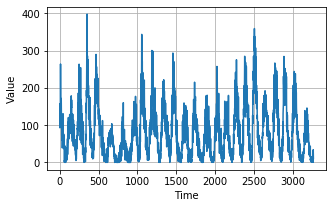

In [155]:
import csv
time_step = []
sunspots = []

with open('source/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(5, 3))
plot_series(time, series)

In [156]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [157]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [158]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

We'll start with a 1D convolution that we'll learn 32 filters.

In [159]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 60
batch_size = 64
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32,
                         kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
46/46 [==============================] - 2s 37ms/step - loss: 123.8350 - mae: 124.3340 - lr: 1.0000e-08
Epoch 2/100
46/46 [==============================] - 2s 37ms/step - loss: 117.4797 - mae: 117.9788 - lr: 1.1220e-08
Epoch 3/100
46/46 [==============================] - 2s 37ms/step - loss: 107.2917 - mae: 107.7900 - lr: 1.2589e-08
Epoch 4/100
46/46 [==============================] - 2s 37ms/step - loss: 99.1682 - mae: 99.6665 - lr: 1.4125e-08
Epoch 5/100
46/46 [==============================] - 2s 37ms/step - loss: 93.2069 - mae: 93.7048 - lr: 1.5849e-08
Epoch 6/100
46/46 [==============================] - 2s 36ms/step - loss: 87.6769 - mae: 88.1744 - lr: 1.7783e-08
Epoch 7/100
46/46 [==============================] - 2s 40ms/step - loss: 82.0391 - mae: 82.5363 - lr: 1.9953e-08
Epoch 8/100
46/46 [==============================] - 2s 37ms/step - loss: 75.8562 - mae: 76.3536 - lr: 2.2387e-08
Epoch 9/100
46/46 [==============================] - 2s 36ms/step - loss: 68.1630 

This will output to a couple of LSTMs with 64 cells each before feeding into a DNN similar to what we saw earlier, 30 neurons, then 10, and one. 

Finally, as **our numbers are in the 1-400 range,** there is a **Lambda** layer that multiplies out our X by 400.

With the first test run to establish the best learning, rate we get this chart. This suggests **the best learning rate for this network will be around 10 to the minus 5.**

[1e-08, 0.0001, 0, 60]

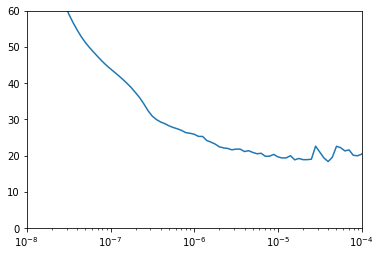

In [160]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

So when I trained for **500 epochs** with this setup, here's my results. It's pretty good with a nice low MAE.

But when I look at my **loss function** during training, I can see that there's a lot of noise which tells me that I can certainly optimize it a bit, and as we saw from earlier videos, one of the best things to look at in these circumstances is **the batch size. So I'll increase it to 256 and retrain.**

In [161]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [162]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32,
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 2s 190ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 2s 188ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 2s 192ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 2s 197ms/step - loss: 72.2679 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 2s 196ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 2s 187ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 2s 204ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 2s 188ms/step - loss: 58.1406 - mae: 58.6369 - lr: 2.2387e-0871 - mae: 58.23
Epoch 9/100
12/12 [==============================] - 2s 189ms/ste

[1e-08, 0.0001, 0, 60]

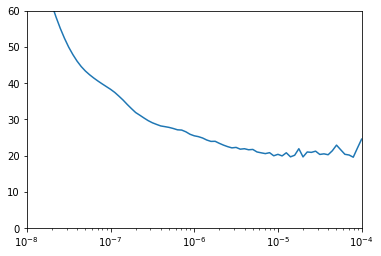

In [163]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [164]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

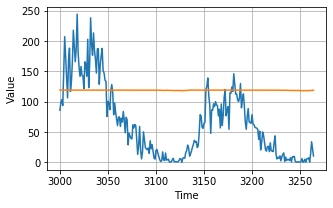

In [165]:
plt.figure(figsize=(5, 3))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [166]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

70.141136

In [167]:
history = model.fit(train_set, epochs=500, callbacks=[lr_schedule])

Epoch 1/500
12/12 [==============================] - 3s 225ms/step - loss: 179.2994 - mae: 179.7991 - lr: 1.0000e-08
Epoch 2/500
12/12 [==============================] - 2s 200ms/step - loss: 332.0546 - mae: 332.5546 - lr: 1.1220e-08
Epoch 3/500
12/12 [==============================] - 3s 208ms/step - loss: 376.2139 - mae: 376.7139 - lr: 1.2589e-08
Epoch 4/500
12/12 [==============================] - 2s 198ms/step - loss: 388.4977 - mae: 388.9977 - lr: 1.4125e-08
Epoch 5/500
12/12 [==============================] - 2s 198ms/step - loss: 391.7600 - mae: 392.2599 - lr: 1.5849e-08
Epoch 6/500
12/12 [==============================] - 2s 198ms/step - loss: 392.4489 - mae: 392.9489 - lr: 1.7783e-08
Epoch 7/500
12/12 [==============================] - 2s 203ms/step - loss: 392.3828 - mae: 392.8828 - lr: 1.9953e-08
Epoch 8/500
12/12 [==============================] - 2s 201ms/step - loss: 392.0713 - mae: 392.5713 - lr: 2.2387e-08
Epoch 9/500
12/12 [==============================] - 2s 195ms/st

Epoch 71/500
12/12 [==============================] - 2s 197ms/step - loss: 31.8261 - mae: 32.3210 - lr: 3.1623e-05
Epoch 72/500
12/12 [==============================] - 2s 197ms/step - loss: 40.0399 - mae: 40.5367 - lr: 3.5481e-05
Epoch 73/500
12/12 [==============================] - 2s 198ms/step - loss: 34.7033 - mae: 35.1997 - lr: 3.9811e-05
Epoch 74/500
12/12 [==============================] - 3s 210ms/step - loss: 31.4809 - mae: 31.9765 - lr: 4.4668e-05
Epoch 75/500
12/12 [==============================] - 2s 197ms/step - loss: 62.6509 - mae: 63.1494 - lr: 5.0119e-05
Epoch 76/500
12/12 [==============================] - 2s 198ms/step - loss: 52.1620 - mae: 52.6599 - lr: 5.6234e-05
Epoch 77/500
12/12 [==============================] - 2s 197ms/step - loss: 47.2316 - mae: 47.7293 - lr: 6.3096e-05
Epoch 78/500
12/12 [==============================] - 2s 200ms/step - loss: 40.1639 - mae: 40.6602 - lr: 7.0795e-05
Epoch 79/500
12/12 [==============================] - 3s 219ms/step - lo

Epoch 208/500
12/12 [==============================] - 3s 237ms/step - loss: 55137864.0000 - mae: 55137864.0000 - lr: 223.8721
Epoch 209/500
12/12 [==============================] - 3s 223ms/step - loss: 61866508.0000 - mae: 61866508.0000 - lr: 251.1886
Epoch 210/500
12/12 [==============================] - 3s 258ms/step - loss: 69414592.0000 - mae: 69414592.0000 - lr: 281.8383
Epoch 211/500
12/12 [==============================] - 3s 220ms/step - loss: 77885080.0000 - mae: 77885080.0000 - lr: 316.2278
Epoch 212/500
12/12 [==============================] - 3s 288ms/step - loss: 87387696.0000 - mae: 87387696.0000 - lr: 354.8134
Epoch 213/500
12/12 [==============================] - 4s 333ms/step - loss: 98051664.0000 - mae: 98051664.0000 - lr: 398.1072
Epoch 214/500
12/12 [==============================] - 4s 302ms/step - loss: 110014936.0000 - mae: 110014936.0000 - lr: 446.6836
Epoch 215/500
12/12 [==============================] - 3s 282ms/step - loss: 123439832.0000 - mae: 123439832.

12/12 [==============================] - 4s 296ms/step - loss: 55138311995392.0000 - mae: 55138311995392.0000 - lr: 223872112.0000
Epoch 329/500
12/12 [==============================] - 3s 285ms/step - loss: 61866252435456.0000 - mae: 61866252435456.0000 - lr: 251188640.0000
Epoch 330/500
12/12 [==============================] - 3s 280ms/step - loss: 69415043334144.0000 - mae: 69415043334144.0000 - lr: 281838304.0000
Epoch 331/500
12/12 [==============================] - 4s 308ms/step - loss: 77884752396288.0000 - mae: 77884752396288.0000 - lr: 316227776.0000
Epoch 332/500
12/12 [==============================] - ETA: 0s - loss: 87388357394432.0000 - mae: 87388357394432.000 - 4s 349ms/step - loss: 87388357394432.0000 - mae: 87388357394432.0000 - lr: 354813376.0000
Epoch 333/500
12/12 [==============================] - 3s 286ms/step - loss: 98051393847296.0000 - mae: 98051393847296.0000 - lr: 398107168.0000
Epoch 334/500
12/12 [==============================] - 4s 340ms/step - loss: 110

12/12 [==============================] - 4s 317ms/step - loss: 11001514335922028544.0000 - mae: 11001514335922028544.0000 - lr: 44668360327168.0000
Epoch 435/500
12/12 [==============================] - 4s 292ms/step - loss: 12343886092041191424.0000 - mae: 12343886092041191424.0000 - lr: 50118724157440.0000
Epoch 436/500
12/12 [==============================] - 3s 285ms/step - loss: 13850124663117578240.0000 - mae: 13850124663117578240.0000 - lr: 56234132635648.0000
Epoch 437/500
12/12 [==============================] - 4s 295ms/step - loss: 15540133408637190144.0000 - mae: 15540133408637190144.0000 - lr: 63095732961280.0000
Epoch 438/500
12/12 [==============================] - 4s 299ms/step - loss: 17436270897550852096.0000 - mae: 17436270897550852096.0000 - lr: 70794575085568.0000
Epoch 439/500
12/12 [==============================] - 4s 304ms/step - loss: 19563863280692756480.0000 - mae: 19563863280692756480.0000 - lr: 79432819671040.0000
Epoch 440/500
12/12 [=====================

[1e-08, 0.0001, 0, 60]

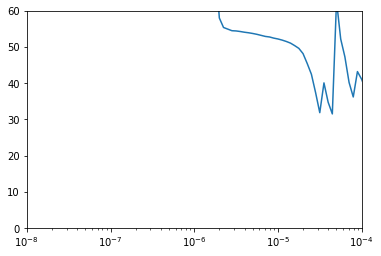

In [168]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [169]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

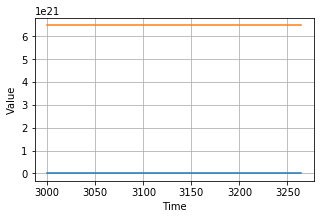

In [170]:
plt.figure(figsize=(5, 3))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [171]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.4868053e+21

<Figure size 432x288 with 0 Axes>

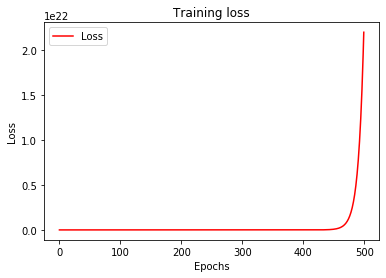

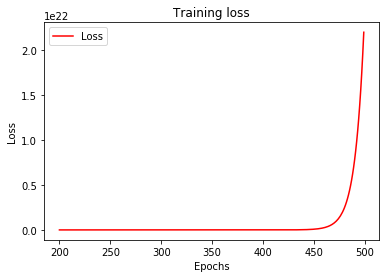

<Figure size 432x288 with 0 Axes>

In [172]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

After 500 epochs, our predictions have improved a little which is a step in the right direction.

But look at our training noise. Particularly towards the end of the training is **really noisy** but it's a very regular looking wave. This suggests that **our larger batch size was good, but maybe a little off.** It's not catastrophic because as you can see the fluctuations are really small but it would be very nice if we could **regularize this loss a bit more,** which then brings me to another thing to try.

Our training data has 3,000 data points in it. So why are things like our window size and batch size powers of two that aren't necessarily evenly divisible into 3,000? What would happen if I were to change my parameters to suit, and not just the window and batch size, **how about changing the filters too?** So what if I **set that to 60, and the LSTMs to 60 instead of 32 or 64?** My DNN already look good, so I won't change them.

So after training this for 500 epochs, our scores improved again albeit slightly. So it shows we're heading in the right direction. What's interesting is that **the noise and the loss function actually increased the bits,** and that made me want to **experiment with the batch size again.** So I reduced it to just 100 and I got these results.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60,
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=500)

In [26]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

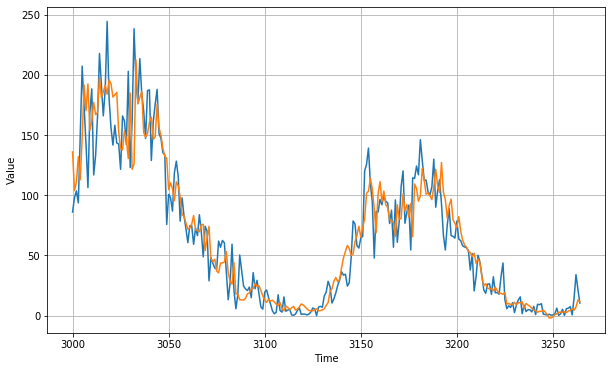

In [27]:
plt.figure(figsize=(5, 3))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Now here our **MAE has actually gone up a little**. The projections are doing much better in the higher peaks than earlier but the **overall accuracy has gone down,** and the loss has smoothed out except for a couple of large blips.

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

13.705887

<Figure size 432x288 with 0 Axes>

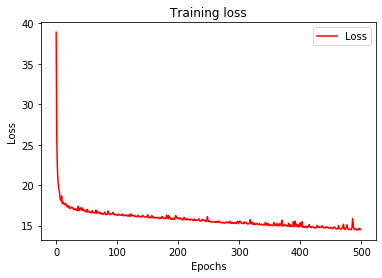

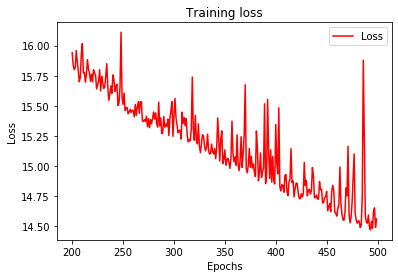

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

Experimenting with hyperparameters like this is a great way to learn the ins and outs of machine learning, not just with sequences but with anything. I thoroughly recommend spending time on it and seeing if you can improve on this model. In addition, you should accompany that work with looking deeper into how all of these things in machine learning work and Andrews courses are terrific for that. I strongly recommend them if you haven't done them already.

# Sunspots data : only DNN version

In [31]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [32]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

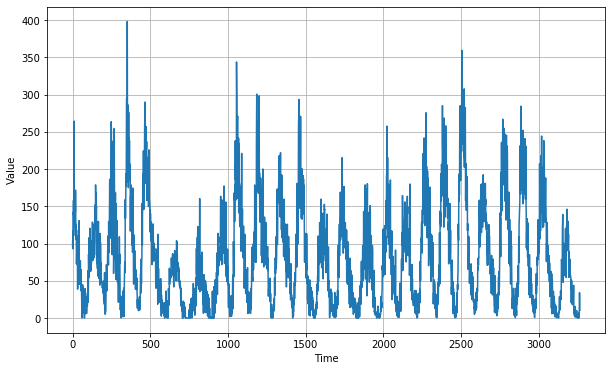

In [34]:
import csv
time_step = []
sunspots = []

with open('source/sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [35]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [36]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()